# Amazon Fine Food Review Analysis using K- Nearest Neighbors

# Loading the data

I used SQLite to load the dataset as it is available in both 'csv' and 'SQLite Database'

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import seaborn as sn
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

I am not taking the datapoints which have Score = 3 because I am considering the score above 3 as positive and below 
3 are negative. I am following the method which I learned from the videos i.e; to get the global sentiment of the recommendations (positive or negative). So purposefully ignore all Scores equal to 3.


In [3]:
sql_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [5]:
#changing reviews with score less than 3 to be positive and negative
Score = sql_data['Score']
positive_Negative = Score.map(partition) 
sql_data['Score'] = positive_Negative

In [6]:
sql_data.shape #looking at the number of attributes and size of the data
sql_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis as observed in course videos

In [7]:
duplicate_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", con)
print(duplicate_data)

       Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=sql_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sql_data['Id'].size*1.0)*100

69.25890143662969

In [11]:
duplicate_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)
print(duplicate_data)

      Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...  


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#positive and negative reviews are left after modification
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [13]:
# Only two datapoints are deleted it means remaining datapoints have HelpfulnessNumerator is less than or equal to HelpfulnessDenominator
print(final.shape)

(364171, 10)


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(sent)
        break;
    i += 1; 

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [21]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                #print('----',cleaned_words)
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    #print('sssssss',s)
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
print('done')

done


In [22]:
final['CleanedText']=final_string

In [23]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [21]:
filtered_data_sample_3000 = final.sample(frac=0.01)
labels_sample_3000 = filtered_data_sample_3000['Score']
print(labels_sample_3000.shape)
print(filtered_data_sample_3000.shape)

(3642,)
(3642, 10)


This dataset has a Time series column and it is recommended to sort the data according to time.

In [22]:
print(filtered_data_sample_3000.head())

            Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
43668    47522  B001E50TJC  A16CURUYGB9NHD          jb                     0   
162814  176523  B004DIZZA0  A39ALRPNB46WGH      DCinMI                     0   
446578  482833  B00068DSHS  A2HTTZ1Q68CON0       Larry                     0   
514771  556568  B001EO6EMO  A24RY06QBQU9LT       Irene                     0   
343043  371119  B001EQ4IMA  A2M6OZ8KDJGIJK     Thistle                     1   

        HelpfulnessDenominator     Score        Time        Summary  \
43668                        0  positive  1332720000  Great Coffee!   
162814                       1  positive  1339977600     I love it!   
446578                       0  positive  1350086400   BIG PIG EARS   
514771                       0  positive  1206403200     Perfection   
343043                       2  negative  1230422400    Weak flavor   

                                                     Text  
43668   This coffee is a little 

In [23]:
sorted_data=filtered_data_sample_3000.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
labels_3000 = sorted_data['Score']
print(labels_3000.shape)
print(sorted_data.shape)

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final_sample.sqlite')
c=conn.cursor()
conn.text_factory = str
sorted_data.to_sql('Reviews_Sample', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

(3642,)
(3642, 10)


# Bag of Words

In [21]:
# Reading data from the saved sample SQLite
import sqlite3
import pandas as pd
con = sqlite3.connect('final_sample.sqlite')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
sorted_data = pd.read_sql_query("""SELECT * FROM Reviews_Sample""", con)
labels_3000 = sorted_data['Score']
print(labels_3000.shape)

(3642,)


In [22]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_data['Text'].values)
final_counts_array = final_counts.toarray()
print(final_counts_array.shape)

(3642, 13341)


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Applying knn algorithm using brute force technique to find the optimal k on BOW

In [45]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts_array, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_brute_bow = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_brute_bow.append(scores.mean())

print(cv_scores_brute_bow)

[0.7880973852516757, 0.8245454355240307, 0.8346639675266252, 0.837457298488621, 0.8368892585385586, 0.8368986741433544, 0.8368924319461009, 0.8357782171726683, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8352101772226058, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829]


In [48]:
# changing to misclassification error
MSE_bow_brute = [1 - x for x in cv_scores_brute_bow]

# determining best k
optimal_k_bow_brute = neighbors[MSE_bow_brute.index(min(MSE_bow_brute))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow_brute)


The optimal number of neighbors is 7.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


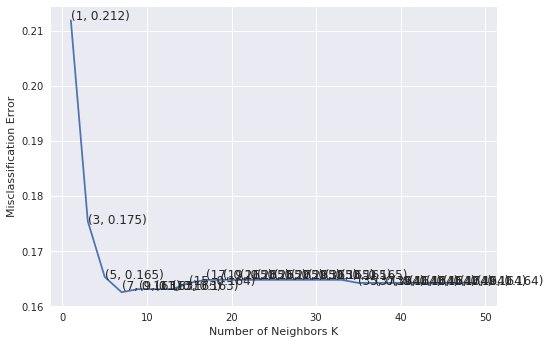

the misclassification error for each k value is :  [0.212 0.175 0.165 0.163 0.163 0.163 0.163 0.164 0.165 0.165 0.165 0.165
 0.165 0.165 0.165 0.165 0.165 0.164 0.164 0.164 0.164 0.164 0.164 0.164
 0.164]


In [49]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_bow_brute)

for xy in zip(neighbors, np.round(MSE_bow_brute,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_bow_brute,3))

In [50]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow_brute)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow_brute, acc))


The accuracy of the knn classifier for k = 7 is 84.263495%


# Applying knn algorithm using kd-tree technique to find the optimal k on BOW

In [51]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts_array, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_kdtree_bow = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_kdtree_bow.append(scores.mean())

print(cv_scores_kdtree_bow)

[0.8257286809251905, 0.8363464509908018, 0.8385747398651032, 0.838019219182158, 0.8402538560536664, 0.8402569945885983, 0.8391365376179122, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664, 0.8402538560536664]


In [52]:
# changing to misclassification error
MSE_bow_kdtree = [1 - x for x in cv_scores_kdtree_bow]

# determining best k
optimal_k_bow_kdtree = neighbors[MSE_bow_kdtree.index(min(MSE_bow_kdtree))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_bow_kdtree)


The optimal number of neighbors is 11.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


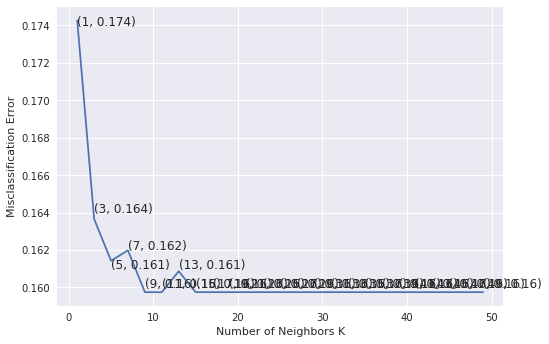

the misclassification error for each k value is :  [0.174 0.164 0.161 0.162 0.16  0.16  0.161 0.16  0.16  0.16  0.16  0.16
 0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
 0.16 ]


In [53]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_bow_kdtree)

for xy in zip(neighbors, np.round(MSE_bow_kdtree,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_bow_kdtree,3))

In [54]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow_kdtree)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow_kdtree, acc))


The accuracy of the knn classifier for k = 11 is 84.903934%


# TF-IDF

In [6]:
# using the SQLite Table to read data. the final.sqlite is the pre-processed data stored in database
# Reading data from the saved sample SQLite
con = sqlite3.connect('final_sample.sqlite')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
sorted_data = pd.read_sql_query("""SELECT * FROM Reviews_Sample""", con)
print(sorted_data.head())

    index      Id   ProductId          UserId              ProfileName  \
0  444050  480138  B0001392MI  A2NDIHTV4992UU             Maggie Dwyer   
1  362699  392246  B0000TL5HI   A2NOYX7RHIXD5      Dr. emily Greenspan   
2  401781  434430  B0000CA4TK   AJHU1QA9QZUC5  J. Jackson "ajacksonsf"   
3  416185  450089  B0000CH39R   AXBTUPPPX2UKV               B. Roberts   
4  178895  194008  B0000YQRQM  A2BW82RCKSMYPR                  cuimhne   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     3                       3  positive  1071619200   
1                     2                       2  positive  1073606400   
2                     4                       5  positive  1073865600   
3                    23                      33  negative  1091145600   
4                     2                       2  positive  1092787200   

                                             Summary  \
0  Best Low Carb-Low Fat All Natural Truffles in ...   
1   

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sorted_data['Text'].values)
print(final_tf_idf.shape)

(3642, 133068)


/root/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


# Applying knn algorithm using brute force technique to find the optimal k on TF-IDF

In [56]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_tf_idf, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_tfidf_brute = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_tfidf_brute.append(scores.mean())

print(cv_scores_tfidf_brute)

[0.7797549501670398, 0.8284684646984566, 0.8385372334860755, 0.8413555681096951, 0.8435996205859994, 0.8447232160916174, 0.8424885443474986, 0.8408000125541397, 0.8441676605360617, 0.8413586717720168, 0.8407999776815295, 0.8396701399786579, 0.839108342225849, 0.83854654447304, 0.8385496830079718, 0.839108342225849, 0.8374323296996072, 0.8363181149261747, 0.8346420675273227, 0.8335247490915686, 0.8335247490915686, 0.8335185068943151, 0.8335185068943151, 0.8335185068943151, 0.8329629513387596]


In [57]:
# changing to misclassification error
MSE_tfidf_brute = [1 - x for x in cv_scores_tfidf_brute]

# determining best k
optimal_k_tfidf_brute = neighbors[MSE_tfidf_brute.index(min(MSE_tfidf_brute))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf_brute)


The optimal number of neighbors is 11.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


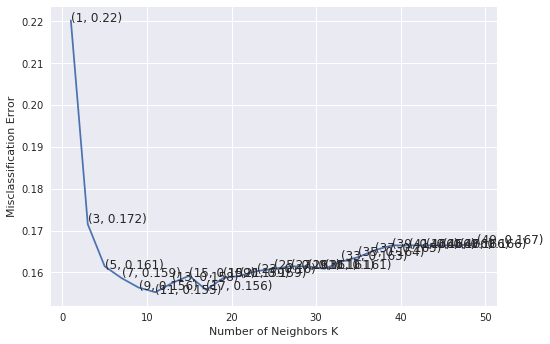

the misclassification error for each k value is :  [0.22  0.172 0.161 0.159 0.156 0.155 0.158 0.159 0.156 0.159 0.159 0.16
 0.161 0.161 0.161 0.161 0.163 0.164 0.165 0.166 0.166 0.166 0.166 0.166
 0.167]


In [58]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_tfidf_brute)

for xy in zip(neighbors, np.round(MSE_tfidf_brute,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_tfidf_brute,3))

In [59]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_brute)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf_brute, acc))


The accuracy of the knn classifier for k = 11 is 86.093321%


# Applying knn algorithm using kd_tree technique to find the optimal k on TF-IDF

In [60]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts_array, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_kdtree_tfidf = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_kdtree_tfidf.append(scores.mean())

print(cv_scores_kdtree_tfidf)

[0.792091583513223, 0.8290639505749903, 0.8391544822357151, 0.8374564284465459, 0.8357804507929145, 0.8352154790415021, 0.8352091665079667, 0.8346473687551578, 0.8340887095372806, 0.8346505072900896, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806, 0.8340887095372806]


In [61]:
# changing to misclassification error
MSE_tfidf_kd_tree = [1 - x for x in cv_scores_kdtree_tfidf]

# determining best k
optimal_k_tfidf_kdtree = neighbors[MSE_tfidf_kd_tree.index(min(MSE_tfidf_kd_tree))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tfidf_kdtree)


The optimal number of neighbors is 5.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


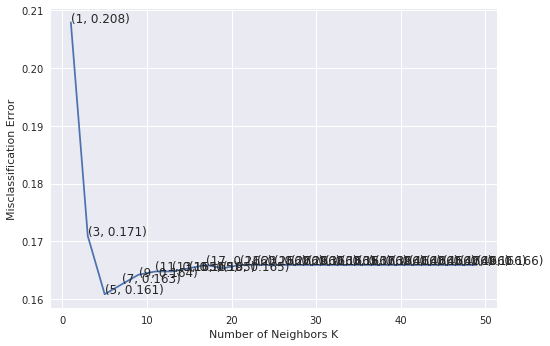

the misclassification error for each k value is :  [0.208 0.171 0.161 0.163 0.164 0.165 0.165 0.165 0.166 0.165 0.166 0.166
 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166 0.166
 0.166]


In [62]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_tfidf_kd_tree)

for xy in zip(neighbors, np.round(MSE_tfidf_kd_tree,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_tfidf_kd_tree,3))

In [63]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_kdtree)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tfidf_kdtree, acc))


The accuracy of the knn classifier for k = 5 is 84.263495%


# W2V

In [8]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(model)

In [9]:
model.wv.similarity('woman', 'man')

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


0.7664012230995352

In [10]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in sorted_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
print(len(list_of_sent))

3642


In [11]:
print(sorted_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

These Truffles are the absolute best tasting truffle made in America. I can't believe they are low in calories, low in carbs, low in fat, all natural and still tastes like the richest chocolate truffle ever made.
*****************************************************************
['these', 'truffles', 'are', 'the', 'absolute', 'best', 'tasting', 'truffle', 'made', 'in', 'america', 'i', 'cant', 'believe', 'they', 'are', 'low', 'in', 'calories', 'low', 'in', 'carbs', 'low', 'in', 'fat', 'all', 'natural', 'and', 'still', 'tastes', 'like', 'the', 'richest', 'chocolate', 'truffle', 'ever', 'made']


In [12]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [13]:
words = list(w2v_model.wv.vocab)
print(len(words))

3648


# Average W2V

In [14]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(list_of_sent[0])

3642
50
['these', 'truffles', 'are', 'the', 'absolute', 'best', 'tasting', 'truffle', 'made', 'in', 'america', 'i', 'cant', 'believe', 'they', 'are', 'low', 'in', 'calories', 'low', 'in', 'carbs', 'low', 'in', 'fat', 'all', 'natural', 'and', 'still', 'tastes', 'like', 'the', 'richest', 'chocolate', 'truffle', 'ever', 'made']


In [15]:
print(sent_vectors[0])

[-0.28619012  0.16552584 -0.07004142 -0.18138394 -0.12394943 -0.15034824
  0.10565843  0.56967223 -0.34285108  0.12690574 -0.0038208  -0.06481494
 -0.24266573  0.27209207 -0.14414287 -0.34057671 -0.24557696 -0.53524605
  0.202167    0.5897261   0.97162551  0.40575628 -0.62543331 -0.17391882
  0.32511988  0.1370605   0.09146362 -0.58427502  0.08103257 -0.31242071
 -0.46832094 -0.27754126  0.57565322  0.33524798  0.2398807  -0.31445785
 -0.09736579 -0.11414391  0.0740068  -0.48576604  0.21313101 -0.44312886
 -0.31421095  0.0980889   0.10296572 -0.522918   -0.00965548  0.30902582
 -0.93496713  0.49738655]


# Applying knn algorithm using brute force technique to find the optimal k on Avg W2V

In [76]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(sent_vectors, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_brute_avgw2v = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_brute_avgw2v.append(scores.mean())

print(cv_scores_brute_avgw2v)

[0.725922450289094, 0.7847796399751708, 0.8066210184197127, 0.8161590958229589, 0.8245517125938946, 0.8307157952001338, 0.8323980499236289, 0.8329598825490482, 0.8329661247463018, 0.833524783964179, 0.8357688364404829, 0.835207038687674, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829, 0.8357688364404829]


In [77]:
# changing to misclassification error
MSE_brute_avgw2v = [1 - x for x in cv_scores_brute_avgw2v]

# determining best k
optimal_k_avgw2v_brute = neighbors[MSE_brute_avgw2v.index(min(MSE_brute_avgw2v))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgw2v_brute)


The optimal number of neighbors is 21.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


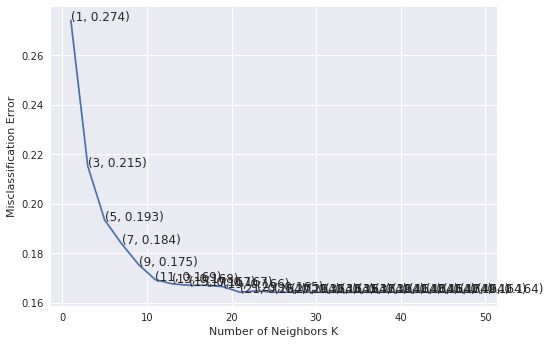

the misclassification error for each k value is :  [0.274 0.215 0.193 0.184 0.175 0.169 0.168 0.167 0.167 0.166 0.164 0.165
 0.164 0.164 0.164 0.164 0.164 0.164 0.164 0.164 0.164 0.164 0.164 0.164
 0.164]


In [78]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_brute_avgw2v)

for xy in zip(neighbors, np.round(MSE_brute_avgw2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_brute_avgw2v,3))

In [79]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v_brute)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v_brute, acc))


The accuracy of the knn classifier for k = 21 is 85.086917%


# Applying knn algorithm using kd_tree technique to find the optimal k on Avg W2V

In [81]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(sent_vectors, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_kdtree_avgw2v = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_kdtree_avgw2v.append(scores.mean())

print(cv_scores_kdtree_avgw2v)

[0.7349083104503993, 0.7998958431966671, 0.813912823911877, 0.8290408105293059, 0.8363223179623143, 0.8363475680964555, 0.8385822049679639, 0.839140864185841, 0.8402581826215952, 0.8391345516523057, 0.8391345516523057, 0.839140864185841, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057, 0.8391345516523057]


In [82]:
# changing to misclassification error
MSE_kdtree_avgw2v = [1 - x for x in cv_scores_kdtree_avgw2v]

# determining best k
optimal_k_avgw2v_kdtree = neighbors[MSE_kdtree_avgw2v.index(min(MSE_kdtree_avgw2v))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgw2v_kdtree)


The optimal number of neighbors is 17.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


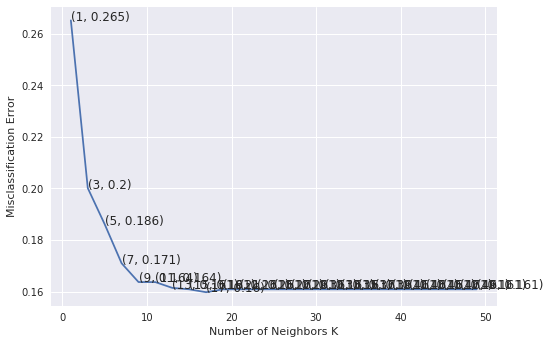

the misclassification error for each k value is :  [0.265 0.2   0.186 0.171 0.164 0.164 0.161 0.161 0.16  0.161 0.161 0.161
 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161 0.161
 0.161]


In [83]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_kdtree_avgw2v)

for xy in zip(neighbors, np.round(MSE_kdtree_avgw2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_kdtree_avgw2v,3))

In [84]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v_kdtree)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgw2v_kdtree, acc))


The accuracy of the knn classifier for k = 17 is 84.903934%


# Avg TF-IDF

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec = sent_vec + (vec * tfidf)
            weight_sum = weight_sum + tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# Applying knn algorithm using brute technique to find the optimal k on Avg TFIDF

In [25]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tfidf_sent_vectors, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_brute_avgtfidf = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_brute_avgtfidf.append(scores.mean())

print(cv_scores_brute_avgtfidf)

[0.7545544929457437, 0.8144410907632385, 0.8452776929604967, 0.8480740566574709, 0.8525591294661619, 0.855380778760949, 0.8559520630458968, 0.8559488890472933, 0.8570756585515147, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022, 0.8565106868001022]


In [30]:
# changing to misclassification error
MSE_brute_avgtfidf = [1 - x for x in cv_scores_brute_avgtfidf]

# determining best k
optimal_k_avgtfidf_brute = neighbors[MSE_brute_avgtfidf.index(min(MSE_brute_avgtfidf))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgtfidf_brute)


The optimal number of neighbors is 17.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


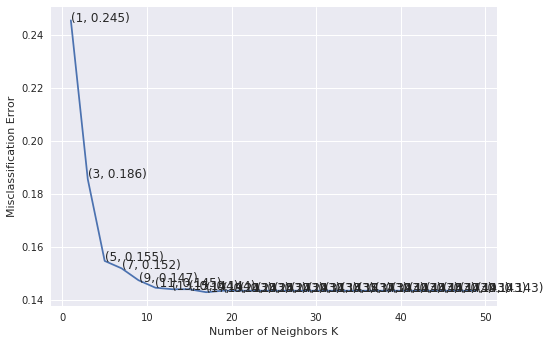

the misclassification error for each k value is :  [0.245 0.186 0.155 0.152 0.147 0.145 0.144 0.144 0.143 0.143 0.143 0.143
 0.143 0.143 0.143 0.143 0.143 0.143 0.143 0.143 0.143 0.143 0.143 0.143
 0.143]


In [33]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_brute_avgtfidf)

for xy in zip(neighbors, np.round(MSE_brute_avgtfidf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_brute_avgtfidf,3))

In [28]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgtfidf_brute)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgtfidf_brute, acc))


The accuracy of the knn classifier for k = 17 is 83.989021%


# Applying knn algorithm using kd_tree technique to find the optimal k on Avg TFIDF

In [29]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(tfidf_sent_vectors, labels_3000, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores_kdtree_avgtfidf = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores_kdtree_avgtfidf.append(scores.mean())

print(cv_scores_kdtree_avgtfidf)

[0.7455466494455076, 0.7914699408146785, 0.8155551997367176, 0.836881934699323, 0.8402591401407269, 0.8424906384773034, 0.8436205819801282, 0.8413796325750844, 0.8424969510108387, 0.8436174079815247, 0.8447347264172789, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913, 0.8452996981686913]


In [31]:
# changing to misclassification error
MSE_kdtree_avgtfidf = [1 - x for x in cv_scores_kdtree_avgtfidf]

# determining best k
optimal_k_avgtfidf_kdtree = neighbors[MSE_kdtree_avgtfidf.index(min(MSE_kdtree_avgtfidf))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_avgtfidf_kdtree)


The optimal number of neighbors is 23.


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


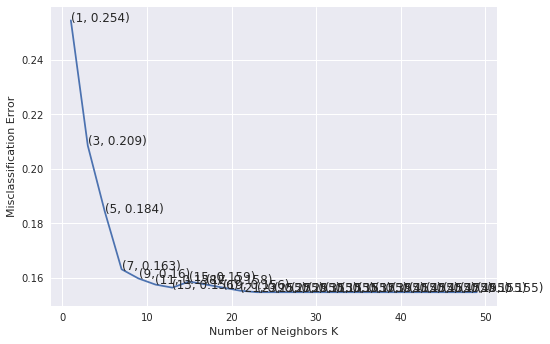

the misclassification error for each k value is :  [0.254 0.209 0.184 0.163 0.16  0.158 0.156 0.159 0.158 0.156 0.155 0.155
 0.155 0.155 0.155 0.155 0.155 0.155 0.155 0.155 0.155 0.155 0.155 0.155
 0.155]


In [34]:
# plot misclassification error vs k 
plt.plot(neighbors, MSE_kdtree_avgtfidf)

for xy in zip(neighbors, np.round(MSE_kdtree_avgtfidf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_kdtree_avgtfidf,3))

In [35]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgtfidf_kdtree)

# fitting the model
knn_optimal.fit(X_tr, y_tr)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_avgtfidf_kdtree, acc))


The accuracy of the knn classifier for k = 23 is 83.897530%
